# Bokeh

In [3]:
%%time
# import necessary libraries
import pandas as pd
import geopandas as gpd
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, PrintfTickFormatter, HoverTool
from bokeh.palettes import Plasma256
import pycountry

# Enable notebook output
output_notebook()

# load data stored in a CSV file
df = pd.read_csv('data/ds_salaries.csv')

# Convert two-letter country codes to three-letter codes
df['employee_residence'] = df['employee_residence'].apply(lambda x: pycountry.countries.get(alpha_2=x).alpha_3)

# Group by 'employee_residence' and calculate the average 'salary_in_usd'
avg_salaries = df.groupby('employee_residence')['salary_in_usd'].mean().reset_index()

# Load world shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the average salaries data with the world shapefile
world = world.merge(avg_salaries, left_on='iso_a3', right_on='employee_residence', how='left')

# Create a GeoJSONDataSource from the merged DataFrame
gsource = GeoJSONDataSource(geojson=world.to_json())

# Create a color mapper
color_mapper = LinearColorMapper(palette=Plasma256, low=avg_salaries['salary_in_usd'].min(), high=avg_salaries['salary_in_usd'].max())

# Create a figure
p = figure(title="Average Salary in USD by Country", width=800, height=400)


# Add the map
p.patches('xs', 'ys', source=gsource, fill_color={'field': 'salary_in_usd', 'transform': color_mapper}, line_color='black', line_width=0.5)

# Add hover tool
hover = HoverTool()
hover.tooltips = [("Country", "@name"), ("Average Salary (USD)", "@salary_in_usd")]
p.add_tools(hover)

# Add color bar
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, formatter=PrintfTickFormatter(format="%0.0f"))
p.add_layout(color_bar, 'right')


# Show the plot
show(p)

Loading BokehJS ...

<timed exec>:23: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



CPU times: user 369 ms, sys: 18.7 ms, total: 388 ms
Wall time: 549 ms


# Plotly

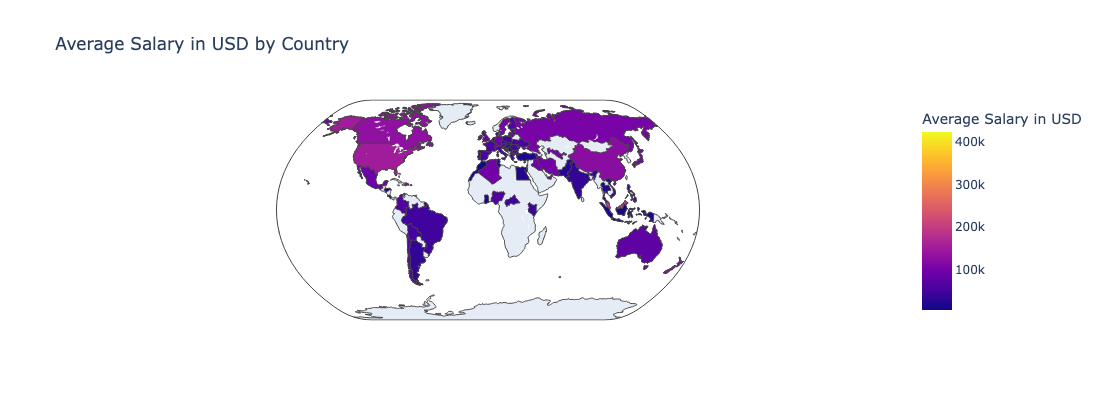

CPU times: user 3.09 s, sys: 1.3 s, total: 4.39 s
Wall time: 10.8 s


In [1]:
%%time
# import necessary libraries
import pandas as pd
import plotly.express as px
import pycountry

# load data stored in a CSV file
df = pd.read_csv('data/ds_salaries.csv')

# Convert two-letter country codes to three-letter codes
df['employee_residence'] = df['employee_residence'].apply(lambda x: pycountry.countries.get(alpha_2=x).alpha_3)

# Group by 'employee_residence' and calculate the average 'salary_in_usd'
avg_salaries = df.groupby('employee_residence')['salary_in_usd'].mean().reset_index()

# Create a world heatmap
fig = px.choropleth(avg_salaries, locations='employee_residence',
                    color='salary_in_usd',
                    hover_name='employee_residence',
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title='Average Salary in USD by Country',
                    labels={'salary_in_usd':'Average Salary in USD'},
                    width=520, 
                    height=400,
                    projection='natural earth')


fig.show()

# ggplot2

Time difference of 0.5161629 secs


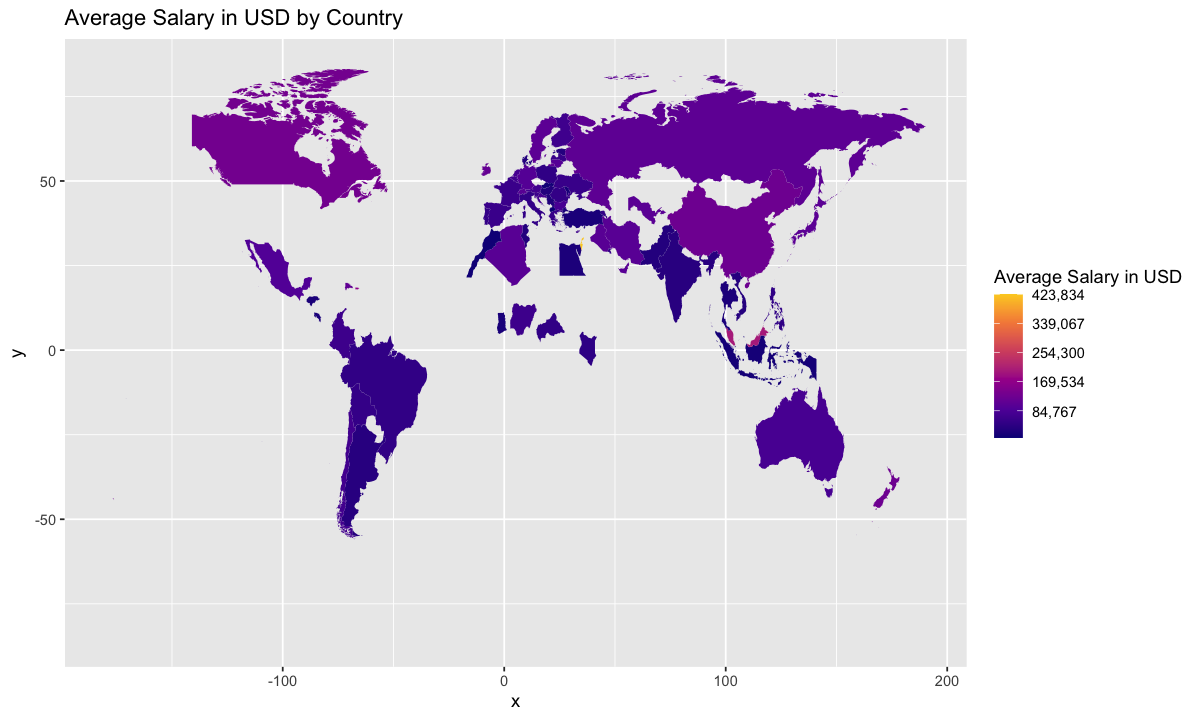

In [3]:
# Measure the execution time of a code block
start.time <- Sys.time()

# Load the necessary libraries
library(ggplot2)
library(countrycode)
library(maps)  # for the 'world' dataset
library(viridis)  # for the 'plasma' color scheme

# load data stored in a CSV file
df <- read.csv('data/ds_salaries.csv')

# Convert two-letter country codes to country names
df$employee_residence <- countrycode(df$employee_residence, 'iso2c', 'country.name')

# Group by 'employee_residence' and calculate the average 'salary_in_usd'
avg_salaries <- aggregate(salary_in_usd ~ employee_residence, df, mean)

# Replace NA values with 0
avg_salaries[is.na(avg_salaries)] <- 0

# Create a dataframe with country codes and average salaries
country_data <- data.frame(
  region = avg_salaries$employee_residence,
  salary_in_usd = avg_salaries$salary_in_usd
)

# Get the world map data
world_map <- map_data('world')

# Set the plot size 
options(repr.plot.width=10, repr.plot.height=6)

# Create a choropleth map
ggplot() +
  geom_map(data=country_data, map=world_map, aes(map_id=region, fill=salary_in_usd)) +
  
  expand_limits(x = world_map$long, y = world_map$lat) +
  scale_fill_viridis_c(name="Average Salary in USD", labels=scales::comma_format(), 
                        breaks=seq(0, max(country_data$salary_in_usd), length.out=6), 
                        option="plasma", direction=1, end=0.9, na.value="grey50") +
  labs(title="Average Salary in USD by Country") 

end.time <- Sys.time()
print(end.time - start.time)

# Leaflet

In [4]:
# Measure the execution time of a code block
start.time <- Sys.time()

# Load the necessary libraries
library(leaflet)
library(countrycode)
library(dplyr)  # for data manipulation
library(rnaturalearth)   # for world map data
library(viridis)  # for color palettes

# Load data stored in a CSV file
df <- read.csv('data/ds_salaries.csv')

# Convert two-letter country codes to country names
df$employee_residence <- countrycode(df$employee_residence, 'iso2c', 'country.name')

# Group by 'employee_residence' and calculate the average 'salary_in_usd'
avg_salaries <- df %>%
  group_by(employee_residence) %>%
  summarise(avg_salary = mean(salary_in_usd, na.rm = TRUE))

# Get the world map data
world_data <- ne_countries(scale = "medium", returnclass = "sf")

# Merge with world data to get country codes
world_data <- merge(world_data, avg_salaries, by.x = 'name', by.y = 'employee_residence', all.x = TRUE)

# Create color palette function
# Remove NA values before passing to colorBin
avg_salary_no_na <- world_data$avg_salary[!is.na(world_data$avg_salary)]
bins <- pretty(avg_salary_no_na)
pal <- colorBin(palette = plasma(5), domain = avg_salary_no_na, bins = bins)

# Create leaflet map
map <- leaflet(data = world_data) %>%
  addTiles() %>%
  setView(lng = 0, lat = 30, zoom = 2) %>%
  addPolygons(fillColor = ~pal(avg_salary),
              fillOpacity = 0.7,
              color = "black",
              weight = 1,
              highlight = highlightOptions(
                weight = 2,
                color = "black",
                fillOpacity = 0.7,
                bringToFront = TRUE),
              label = ~paste(name, ": $", avg_salary)) %>%
  addLegend(pal = pal, values = ~avg_salary, title = "Average Salary",
            position = "bottomleft", opacity = 1)

# Print map
map

# Measure execution time
end.time <- Sys.time()
print(end.time - start.time)

HTML widgets cannot be represented in plain text (need html)

Time difference of 3.091767 secs
